# ArXiv keyword search

We have attempted two supervised models to classify arXiv projects into creative industries without success.

Having given up on that stream of analysis, here we adopt a keyword-based search instead, where we switch between 
a broad and a narrow definition of creative industries related work



## Preamble

In [1]:
%run notebook_preamble.ipy  #Note need to run notebook from Powershell prompt

In [2]:
# Functions etc here

import random
import matplotlib.pyplot as plt
import seaborn as sn

def flatten_list(a_list):
    return([x for el in a_list for x in el])

## Load data etc

In [3]:
arx=pd.read_csv(".../ai_ci/data/processed/deep_learning.csv", dtype={'article_id':str})


Adds in a flag for AI status

In [4]:
#File that contains the AI ids that are matched to the arx article_ids

ai_path = '../ai_ci/data/dl_paper_ids.csv'

ml_ids = pd.read_csv(ai_path,dtype={'paper_id':str})

ml_ids.shape

ml_ids_set = set(list(ml_ids.loc[ml_ids['is_AI']==True,'paper_id']))


arx['ai'] = [x in ml_ids_set for x in arx['article_id']]

In [5]:
arx['article_id'].head(n=5)

0    0704.0002
1    0704.0002
2    0704.0046
3    0704.0046
4    0704.0046
Name: article_id, dtype: object

In [6]:
ml_ids['is_AI'].value_counts()

0    1297943
1      74407
Name: is_AI, dtype: int64

Remove the duplicate papers

In [7]:
arx_papers = arx.drop_duplicates('article_id').reset_index(drop=True)

In [8]:
arx_papers['ai'].value_counts()

False    168851
True      59732
Name: ai, dtype: int64

In [9]:
list(arx_papers)

['Unnamed: 0',
 'article_id',
 'article_created',
 'article_updated',
 'article_title',
 'journal_ref',
 'doi',
 'summary',
 'citation_count',
 'citation_count_updated',
 'arxiv_categories',
 'matching_score',
 'is_multinational',
 'institute_id',
 'institute_name',
 'institute_city',
 'institute_state',
 'institute_country',
 'institute_lat',
 'institute_lon',
 'ai']

In [ ]:
# %load lda_pipeline.py
from gensim import corpora, models
from string import punctuation
from string import digits
import re
import pandas as pd
import numpy as np

#Characters to drop
drop_characters = re.sub('-','',punctuation)+digits

#Stopwords
from nltk.corpus import stopwords

stop = stopwords.words('English')

#Stem functions
from nltk.stem import *
stemmer = PorterStemmer()


def clean_tokenise(string,drop_characters=drop_characters,stopwords=stop):
    '''
    Takes a string and cleans (makes lowercase and removes stopwords)
    
    '''
    

    #Lowercase
    str_low = string.lower()
    
    
    #Remove symbols and numbers
    str_letters = re.sub('[{drop}]'.format(drop=drop_characters),'',str_low)
    
    
    #Remove stopwords
    clean = [x for x in str_letters.split(' ') if (x not in stop) & (x!='')]
    
    return(clean)


class CleanTokenize():
    '''
    This class takes a list of strings and returns a tokenised, clean list of token lists ready
    to be processed with the LdaPipeline
    
    It has a clean method to remove symbols and stopwords
    
    It has a bigram method to detect collocated words
    
    It has a stem method to stem words
    
    '''
    
    def __init__(self,corpus):
        '''
        Takes a corpus (list where each element is a string)
        '''
        
        #Store
        self.corpus = corpus
        
    def clean(self,drop=drop_characters,stopwords=stop):
        '''
        Removes strings and stopwords, 
        
        '''
        
        cleaned = [clean_tokenise(doc,drop_characters=drop,stopwords=stop) for doc in self.corpus]
        
        self.tokenised = cleaned
        return(self)
    
    def stem(self):
        '''
        Optional: stems words
        
        '''
        #Stems each word in each tokenised sentence
        stemmed = [[stemmer.stem(word) for word in sentence] for sentence in self.tokenised]
    
        self.tokenised = stemmed
        return(self)
        
    
    def bigram(self,threshold=10):
        '''
        Optional Create bigrams.
        
        '''
        
        #Colocation detector trained on the data
        phrases = models.Phrases(self.tokenised,threshold=threshold)
        
        bigram = models.phrases.Phraser(phrases)
        
        self.tokenised = bigram[self.tokenised]
        
        return(self)
        
        
        
        

class LdaPipeline():
    '''
    This class processes lists of keywords.
    How does it work?
    -It is initialised with a list where every element is a collection of keywords
    -It has a method to filter keywords removing those that appear less than a set number of times
    
    -It has a method to process the filtered df into an object that gensim can work with
    -It has a method to train the LDA model with the right parameters
    -It has a method to predict the topics in a corpus
    
    '''
    
    def __init__(self,corpus):
        '''
        Takes the list of terms
        '''
        
        #Store the corpus
        self.tokenised = corpus
        
    def filter(self,minimum=5):
        '''
        Removes keywords that appear less than 5 times.
        
        '''
        
        #Load
        tokenised = self.tokenised
        
        #Count tokens
        token_counts = pd.Series([x for el in tokenised for x in el]).value_counts()
        
        #Tokens to keep
        keep = token_counts.index[token_counts>minimum]
        
        #Filter
        tokenised_filtered = [[x for x in el if x in keep] for el in tokenised]
        
        #Store
        self.tokenised = tokenised_filtered
        self.empty_groups = np.sum([len(x)==0 for x in tokenised_filtered])
        
        return(self)
    
    def clean(self):
        '''
        Remove symbols and numbers
        
        '''
        
        
        
    
        
    def process(self):
        '''
        This creates the bag of words we use in the gensim analysis
        
        '''
        #Load the list of keywords
        tokenised = self.tokenised
        
        #Create the dictionary
        dictionary = corpora.Dictionary(tokenised)
        
        #Create the Bag of words. This converts keywords into ids
        corpus = [dictionary.doc2bow(x) for x in tokenised]
        
        self.corpus = corpus
        self.dictionary = dictionary
        return(self)
        
    def tfidf(self):
        '''
        This is optional: We extract the term-frequency inverse document frequency of the words in
        the corpus. The idea is to identify those keywords that are more salient in a document by normalising over
        their frequency in the whole corpus
        
        '''
        #Load the corpus
        corpus = self.corpus
        
        #Fit a TFIDF model on the data
        tfidf = models.TfidfModel(corpus)
        
        #Transform the corpus and save it
        self.corpus = tfidf[corpus]
        
        return(self)
    
    def fit_lda(self,num_topics=20,passes=5,iterations=75,random_state=1803):
        '''
        
        This fits the LDA model taking a set of keyword arguments.
        #Number of passes, iterations and random state for reproducibility. We will have to consider
        reproducibility eventually.
        
        '''
        
        #Load the corpus
        corpus = self.corpus
        
        #Train the LDA model with the parameters we supplied
        lda = models.LdaModel(corpus,id2word=self.dictionary,
                              num_topics=num_topics,passes=passes,iterations=iterations,random_state=random_state)
        
        #Save the outputs
        self.lda_model = lda
        self.lda_topics = lda.show_topics(num_topics=num_topics)
        

        return(self)
    
    def predict_topics(self):
        '''
        This predicts the topic mix for every observation in the corpus
        
        '''
        #Load the attributes we will be working with
        lda = self.lda_model
        corpus = self.corpus
        
        #Now we create a df
        predicted = lda[corpus]
        
        #Convert this into a dataframe
        predicted_df = pd.concat([pd.DataFrame({x[0]:x[1] for x in topics},
                                              index=[num]) for num,topics in enumerate(predicted)]).fillna(0)
        
        self.predicted_df = predicted_df
        
        return(self)
    

### Keyword expansion

In [11]:
from gensim.models import Word2Vec

In [12]:
%time
#Clean and tokenise the arXiv data
arx_papers['summary'] = [re.sub('\n',' ',x) for x in arx_papers['summary']]

arxiv_pro = CleanTokenize(arx_papers['summary']).clean().bigram().bigram()

Wall time: 0 ns


#The original seed no longer used

creative_sector_seed = {
    'Advertising and marketing':['advertising','advert','marketing',
                                 'search_engine','social_media'],
    
    'Architecture':['smart_city','traffic','transportation','house'],
     #'Crafts':
    
    'immersive_games': ['video_game','virtual_reality','augmented_reality'],
    
    'Design':['user_interface','user_interaction','usability'],
     
    'Film, TV, video, radio and photography':['video','film','television','radio','photography','image','photo'],
    
    'IT, software and computer services':['software','programming','software_development'],
    
    'Museums, galleries and libraries':['museum','gallery','archive','exhibition'
                                        #'library','repository'
                                       ],
    
    'Music, performing and visual arts':['music','song','audio','art','artist','creativity','theatre'],
    
    'Publishing': ['printing','book','e-book','book','journalism','newspaper']}

In [13]:
creative_sector_seed_broad = {
    'Advertising and marketing':['advertising','advert','marketing',
                                 'search_engine','social_media'],
    
    'Architecture':['smart_city','traffic','transportation','house'],
     #'Crafts':
    
    'immersive_games': ['video_game','virtual_reality','augmented_reality'],
    
    'Design':['user_interface','user_interaction','usability'],
     
    'Film, TV, video, radio and photography':['video','film','television','radio','photography','image','photo'],
    
    'IT, software and computer services':['software','programming','software_development'],
    
    'Museums, galleries and libraries':['museum','gallery','archive','exhibition'
                                        #'library','repository'
                                       ],
    
    'Music, performing and visual arts':['music','song','audio','art','artist','creativity','theatre'],
    
    'Publishing': ['printing','book','e-book','book','journalism','newspaper', 'text']}

#initialises the state as being broad to start with

state='broad'

In [14]:
# Removes IT,software and computer services

del creative_sector_seed_broad["IT, software and computer services"]


In [15]:
state

'broad'

Functions that pares it down from broad to narrow 

In [16]:
def change_state(y,x):
  if "image" in [s for v in y.values() for s in v]:
    if x=='narrow': # You want the narrow definition so remove the terms you don't want
      for elem in ['image', 'photo', 'video']:
       y['Film, TV, video, radio and photography'].remove(elem)
      y['Music, performing and visual arts'].remove('audio')        
      y['Publishing'].remove('text')
      return y
    elif x=='broad': #You want broad and it already is, do nothing
      return y
  elif "image" not in [s for v in y.values() for s in v]:
     if x=='narrow': #It's already narrow do nothing
      return y
     elif x=='broad': #It';s not narrow add in the missing terms
      y['Film, TV, video, radio and photography'].extend(('image','photo','video'))
      y['Music, performing and visual arts'].append('audio')
      y['Publishing'].append('text')
      return y


Function that varies print destination

In [17]:
# Varies the destination folder by the kind of analysis being done
def printer(x):
    if x=='narrow':
      def saver_narrow(z):
        path='.../ai_ci/reports/figures/'+'narrow_definition/narrow_'
        plt.tight_layout()
        plt.savefig(path+z+'.png')
      return saver_narrow
    elif x=='broad':
       def saver_broad(z):
        path = '.../reports/figures/'+'broad_definition/broad_'
        plt.tight_layout()
        plt.savefig(path+z+'.png')
       return saver_broad


    

# Change the status flag below and rerun the notebook to switch between broad and narrow definitions

In [18]:
status='narrow'

creative_sector_seed=change_state(creative_sector_seed_broad, status)

save_fig=printer(status)

creative_sector_seed

{'Advertising and marketing': ['advertising',
  'advert',
  'marketing',
  'search_engine',
  'social_media'],
 'Architecture': ['smart_city', 'traffic', 'transportation', 'house'],
 'immersive_games': ['video_game', 'virtual_reality', 'augmented_reality'],
 'Design': ['user_interface', 'user_interaction', 'usability'],
 'Film, TV, video, radio and photography': ['film',
  'television',
  'radio',
  'photography'],
 'Museums, galleries and libraries': ['museum',
  'gallery',
  'archive',
  'exhibition'],
 'Music, performing and visual arts': ['music',
  'song',
  'art',
  'artist',
  'creativity',
  'theatre'],
 'Publishing': ['printing',
  'book',
  'e-book',
  'book',
  'journalism',
  'newspaper']}

In [19]:
save_fig=printer(status)

In [20]:
# Trialing the printer function

arx_papers.citation_count.head(n=10)

0     18.0
1      1.0
2      9.0
3      0.0
4     22.0
5      4.0
6     26.0
7      0.0
8     14.0
9    128.0
Name: citation_count, dtype: float64

In [21]:
pd.DataFrame({k:', '.join(v) for k,v in creative_sector_seed.items()},index=['Keywords']).T.to_csv("...//ai_ci//sensitivity_analysis//arxiv_kw_lookupnarrow.csv")

# Does a keyword expansion in word2vec

In [22]:
#Use word2vec
%time
w2v_arx = Word2Vec(arxiv_pro.tokenised,window=20)

Wall time: 0 ns


In [23]:
#This dict comprehension extracts similar terms to the one above, but only if they are above a certain similarity threshold

# k the general categories
# v the words associated with the categories


#Here we go creating the expanded key words set, the general categories stay the same and new words get added in from word2vec
expanded_kws = {k:set(
    # add in the most similar words from the word in the word2vec model  
    flatten_list([[x[0] for x in w2v_arx.wv.most_similar(w) if x[1]>0.8] for w in v])+
    # add in the general categories if they are not in the stop words list
    [w for w in k.lower().split(' ') if w not in stop]
    # adds in the original words the vs
     +[w for w in v]) 
    # Looping over the words and sector keys            
    for k,v in 
    creative_sector_seed.items()}

expanded_kws broad definition

In [24]:
expanded_kws

{'Advertising and marketing': {'ad_impressions',
  'advert',
  'advertisement',
  'advertisements',
  'advertiser',
  'advertisers',
  'advertising',
  'bing',
  'fake_news',
  'forums',
  'google_yahoo',
  'marketers',
  'marketing',
  'news',
  'online_advertising',
  'online_media',
  'online_social_media',
  'products_services',
  'propaganda',
  'purchase',
  'purchases',
  'purchasing',
  'search_engine',
  'search_engines',
  'search_queries',
  'social_media',
  'social_media_platforms',
  'social_media_users',
  'sponsored_search',
  'twitter',
  'user-generated_content',
  'web_search',
  'web_search_engine'},
 'Architecture': {'architecture',
  'house',
  'houses',
  'infrastructures',
  'internet_things',
  'internet_things_iot',
  'office',
  'public_safety',
  'smart_cities',
  'smart_city',
  'traffic',
  'transportation',
  'transportation_systems'},
 'immersive_games': {'augmented_reality',
  'augmented_reality_ar',
  'computer_games',
  'immersive',
  'immersive_games

{'Advertising and marketing': {'ad_impressions',
  'advert',
  'advertisement',
  'advertisements',
  'advertiser',
  'advertisers',
  'advertising',
  'bing',
  'fake_news',
  'forums',
  'google_yahoo',
  'marketers',
  'marketing',
  'news',
  'online_advertising',
  'online_media',
  'online_social_media',
  'products_services',
  'promotions',
  'propaganda',
  'purchase',
  'purchasing',
  'search_engine',
  'search_engines',
  'search_queries',
  'social_media',
  'social_media_platforms',
  'social_media_users',
  'sponsored_search',
  'twitter',
  'user-generated_content',
  'web_search'},
 'Architecture': {'architecture',
  'house',
  'houses',
  'infrastructures',
  'internet_things',
  'internet_things_iot',
  'iot_paradigm',
  'office',
  'public_safety',
  'smart_cities',
  'smart_city',
  'traffic',
  'transportation',
  'transportation_systems'},
 'immersive_games': {'augmented_reality',
  'augmented_reality_ar',
  'computer_games',
  'immersive',
  'immersive_games',
  'mixed_reality',
  'telepresence',
  'video_game',
  'video_games',
  'virtual_environment',
  'virtual_objects',
  'virtual_reality',
  'virtual_reality_vr',
  'virtual_world',
  'vr'},
 'Design': {'design',
  'graphical_user_interface',
  'graphical_user_interface_gui',
  'usability',
  'usability_security',
  'user-friendly',
  'user_interaction',
  'user_interface',
  'user_interfaces',
  'web_application'},
 'Film, TV, video, radio and photography': {'around_world',
  'digital_camera',
  'dsrc',
  'entertainment',
  'film',
  'film,',
  'films',
  'image',
  'images',
  'images_captured',
  'input_image',
  'lora',
  'photo',
  'photograph',
  'photographs',
  'photography',
  'photos',
  'pictures',
  'radio',
  'radio_channel',
  'radios',
  'television',
  'tv,',
  'video',
  'video,',
  'videos',
  'visual_content',
  'wban',
  'wireless',
  'wireless_communication',
  'wireless_devices',
  'wireless_local',
  'wlan'},
 'IT, software and computer services': {'agile_development',
  'computer',
  'development_process',
  'it,',
  'programming',
  'programming_language',
  'scrum',
  'services',
  'software',
  'software_developers',
  'software_development',
  'software_development_process',
  'software_engineering',
  'software_engineers',
  'software_industry',
  'software_project',
  'software_projects'},
 'Museums, galleries and libraries': {'archive',
  'archives',
  'exhibition',
  'galleries',
  'gallery',
  'libraries',
  'museum',
  'museums',
  'museums,',
  'repositories',
  'repository'},
 'Music, performing and visual arts': {'art',
  'artist',
  'artistic',
  'artists',
  'arts',
  'audio',
  'audio_signal',
  'creative',
  'creative_process',
  'creativity',
  'human_creativity',
  'lyrics',
  'music',
  'music,',
  'musical',
  'performing',
  'song',
  'songs',
  'speech',
  'speech_signal',
  'theatre',
  'theatregoers',
  'thinking',
  'visual'},
 'Publishing': {'across_world',
  'blogging',
  'blogs',
  'book',
  'books',
  'charles',
  'debates',
  'e-book',
  'e-books',
  'finnish',
  'full-text',
  'greek',
  'journal_article',
  'journalism',
  'journalists',
  'lecture',
  'lectures',
  'librarians',
  'medieval',
  'newspaper',
  'newspapers',
  'online_media',
  'politicians',
  'politics',
  'printed',
  'printer',
  'printers',
  'printing',
  'proceedings',
  'publishing',
  'rhetoric',
  'russian',
  'scientific_papers',
  'social_media_platforms',
  'turkish',
  'wikipedia_articles'}}

In [25]:
#creative_sector_seed_broad 

pd.DataFrame({k:', '.join(v) for k,v in creative_sector_seed.items()},index=['Keywords']).T.to_csv("...//ai_ci//sensitivity_analysis//arxiv_kw_lookupnarrow.csv")

#This dict comprehension extracts similar terms to the one above, but only if they are above a certain similarity threshold



# k the general categories

# v the words associated with the categories


In [26]:
def drop_terms(kw_set,drop):
    '''
    Function that drops some irrelevant term from the expanded keyword set
    '''
    
    kw_set_2 = {k:set([val for val in v if val not in drop]) for k,v in kw_set.items()}
    
    return(kw_set_2)

# Terms that are dropped from both broad and narrow after inspection

#Afer checking the results, these are the terms that we drop old version
kw_set_2 = drop_terms(expanded_kws,['it,','package','python','services','thinking','charles','fabricate','full-text','greek',
              'lecture','lectures','proceedings','russian','turkish','talks','wikipedia_articles','library','repository',
                                   'architecture','design','designer','finnish','politicians','politics'])

In [27]:
#Afer checking the results, these are the terms that we drop
kw_set_2 = drop_terms(expanded_kws,['it,','package','python','services','thinking','charles','fabricate','full-text','greek', 'debates',
'lecture','lectures','proceedings','russian','turkish','talks','wikipedia_articles','library','repository', 'usability',
  'usability_security','user-friendly','infrastructures', 'internet_things', 'internet_things_iot', 'iot_paradigm', 'office', 'public_safety',           
'rhetoric', 'twitter','traffic', 'transportation', 'transportation_systems','wban','wireless','wireless_communication',
 'wireless_devices','scientific_papers','around_world',  'dsrc' ,'lora', 'repositories',     'wireless_local','wlan','across world','medieval', 'architecture','design',
 'designer','finnish','politicians','politics','journal_article','visual',
'twitter', 'bing', 'fake_news','forums','google_yahoo', 'news',  'propaganda', 'purchase',  'purchasing','social_media',
  'social_media_platforms','social_media_users',   'twitter','user-generated_content', 'web_search', 'web_application'
'across_world',  'evening','curiosity',   'online_social_media'      ])

In [28]:
kw_set_2

{'Advertising and marketing': {'ad_impressions',
  'advert',
  'advertisement',
  'advertisements',
  'advertiser',
  'advertisers',
  'advertising',
  'marketers',
  'marketing',
  'online_advertising',
  'online_media',
  'products_services',
  'purchases',
  'search_engine',
  'search_engines',
  'search_queries',
  'sponsored_search',
  'web_search_engine'},
 'Architecture': {'house', 'houses', 'smart_cities', 'smart_city'},
 'immersive_games': {'augmented_reality',
  'augmented_reality_ar',
  'computer_games',
  'immersive',
  'immersive_games',
  'mixed_reality',
  'telepresence',
  'video_game',
  'video_games',
  'virtual_environment',
  'virtual_objects',
  'virtual_reality',
  'virtual_reality_vr',
  'virtual_world',
  'vr'},
 'Design': {'graphical_user_interface',
  'graphical_user_interface_gui',
  'user_interaction',
  'user_interface',
  'user_interfaces',
  'web_application'},
 'Film, TV, video, radio and photography': {'digital_camera',
  'entertainment',
  'film',
  'f

# Counts the occurrences

In [29]:
#Now we label papers with term occurrences
%time

out = []

#This loops over each list of keywords and counts their occurrences in the tokenised version of the corpus
for k,val in creative_sector_seed.items():
    
    
    #Count the number of occurrences of keywords related to a creative industry in a paper
    res = [len(kw_set_2[k]&set(abst)) for abst in arxiv_pro.tokenised]
    out.append([k,res])

Wall time: 0 ns


In [30]:
#We create a dataframe with the outputs that we stored in the out list above
#Note that we create a prefix for the name to make things easier to read later

out_labels = pd.DataFrame({'kw_n_'+re.sub(' ','_',x[0].lower()):x[1] for x in out})

out_labels.sum()

sect_labels = out_labels.columns

In [31]:
#Concatenate into a single dataframe
arx_pred = pd.concat([arx_papers,out_labels],axis=1)

arx_pred['year'] = [int(x.split('-')[0]) for x in arx_pred['article_created']]

In [32]:
# Cheap check of results

for s in out_labels.columns:
    
    print(s)
    print('===')
        
    arx_temp = arx_pred.loc[arx_pred[s]>1]
    
    
    choose_three = random.sample(list(arx_temp['summary']),5)
    
    for d in choose_three:
        
        print(d)
        print('\n')


kw_n_advertising_and_marketing
===
  Tensors are becoming prevalent in modern applications such as medical imaging and digital marketing. In this paper, we propose a sparse tensor additive regression (STAR) that models a scalar response as a flexible nonparametric function of tensor covariates. The proposed model effectively exploits the sparse and low-rank structures in the tensor additive regression. We formulate the parameter estimation as a non-convex optimization problem, and propose an efficient penalized alternating minimization algorithm. We establish a non-asymptotic error bound for the estimator obtained from each iteration of the proposed algorithm, which reveals an interplay between the optimization error and the statistical rate of convergence. We demonstrate the efficacy of STAR through extensive comparative simulation studies, and an application to the click-through-rate prediction in online advertising. 


  Real-time bidding (RTB) has become a new norm in display adver

In [33]:
list(arx_pred)

['Unnamed: 0',
 'article_id',
 'article_created',
 'article_updated',
 'article_title',
 'journal_ref',
 'doi',
 'summary',
 'citation_count',
 'citation_count_updated',
 'arxiv_categories',
 'matching_score',
 'is_multinational',
 'institute_id',
 'institute_name',
 'institute_city',
 'institute_state',
 'institute_country',
 'institute_lat',
 'institute_lon',
 'ai',
 'kw_n_advertising_and_marketing',
 'kw_n_architecture',
 'kw_n_immersive_games',
 'kw_n_design',
 'kw_n_film,_tv,_video,_radio_and_photography',
 'kw_n_museums,_galleries_and_libraries',
 'kw_n_music,_performing_and_visual_arts',
 'kw_n_publishing',
 'year']

## Descriptive analysis

#### 1. Levels and trends

In [34]:
creative_sectors = sect_labels

sect_labels

Index(['kw_n_advertising_and_marketing', 'kw_n_architecture',
       'kw_n_immersive_games', 'kw_n_design',
       'kw_n_film,_tv,_video,_radio_and_photography',
       'kw_n_museums,_galleries_and_libraries',
       'kw_n_music,_performing_and_visual_arts', 'kw_n_publishing'],
      dtype='object')

In [35]:
def create_sector_distribution(df,ai_var,sector_names,thres,norm=False):
    '''
    Create a table of AI activity per sector.
    
    Args:
        Df is the dataframe where the rows are entities and the columns fields of interest
        ai_var is the variable with AI
        sector_names are the names of the sectors (we assume that the sectors are columns)
        thres is the value in the sector column indicating presence of CI
        norm is whether we want to normalise the output or nor
    
    '''
    
    #Create the distribution
    sector_distr = pd.concat([df.loc[df[sector]>thres][ai_var].value_counts() for sector in sector_names],axis=1).T

    #Prettify the variable names
    sector_distr.index = [' '.join(x.split('_')[2:]).capitalize() for x in sector_names]
    
    
    
    #Do we normalise?
    if norm==False:
        return(sector_distr)
    #Normalise over cols
    elif norm==1:
        return(sector_distr.apply(lambda x: x/x.sum(),axis=1))
    else:
        return(sector_distr.apply(lambda x: x/x.sum(),axis=0))

    
    

In [36]:
#Count the number of AI papers per 'sector area'

ai_in_sector = pd.concat([pd.crosstab(arx_pred['ai'],arx_pred[s]>1)[True] for s in sect_labels],axis=1)
ai_in_sector.columns = sect_labels

ai_in_sector.T


ai,False,True
kw_n_advertising_and_marketing,303,89
kw_n_architecture,26,15
kw_n_immersive_games,178,55
kw_n_design,38,16
"kw_n_film,_tv,_video,_radio_and_photography",74,32
"kw_n_museums,_galleries_and_libraries",47,17
"kw_n_music,_performing_and_visual_arts",324,186
kw_n_publishing,139,51


In [37]:
creative_ai_act = create_sector_distribution(arx_pred,'ai',creative_sectors,thres=1)
creative_ai_act

,False,True
Advertising and marketing,303,89
Architecture,26,15
Immersive games,178,55
Design,38,16
"Film, tv, video, radio and photography",74,32
"Museums, galleries and libraries",47,17
"Music, performing and visual arts",324,186
Publishing,139,51


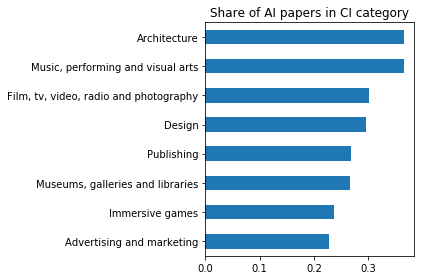

In [39]:




create_sector_distribution(arx_pred,'ai',creative_sectors,thres=1,norm=1).sort_values(True,ascending=True)[True].plot.barh(title='Share of AI papers in CI category',figsize=(6,4))

save_fig('shares')

In [40]:
top_sectors = creative_ai_act.sort_values(True,ascending=False).index

#### 2. Sector overlaps

In [41]:
from sklearn.metrics import pairwise_distances

In [42]:
overlaps = arx_pred[creative_sectors]>1

pd.crosstab(overlaps['kw_n_advertising_and_marketing'],overlaps['kw_n_film,_tv,_video,_radio_and_photography'])


"kw_n_film,_tv,_video,_radio_and_photography",False,True
kw_n_advertising_and_marketing,,
False,228085,106
True,392,0


#### 3. Overal trends

In [43]:
def trend_analysis(df,year_var,ai_var,sector_names,thres,norm=False,year_lims=False):
    
    '''
    
    Function to create table of research trends
    
    Args:
        Df is the dataframe where the rows are entities and the columns fields of interest
        year_var is the variable with the year
        ai_var is the variable with AI
        sector_names are the names of the sectors (we assume that the sectors are columns)
        thres is the value in the sector column indicating presence of CI
        norm is whether we want to normalise the output or nor
        year_lims is the variable with the year limits (min and max)
    
    '''
    
    if norm == False:
        
        sector_year = pd.concat([
            df.loc[df[s]>thres].groupby([year_var,ai_var]).size().reset_index(
                drop=False).pivot_table(index=year_var,columns=ai_var,values=0).fillna(0)[True] for s in sector_names],
            axis=1).fillna(0)
        
    else:
        
        sector_year = pd.concat([
            df.loc[df[s]>thres].groupby([year_var,ai_var]).size().reset_index(
                drop=False).pivot_table(index=year_var,columns=ai_var,values=0).fillna(
                0).apply(lambda x: x/x.sum(),axis=1)[True] for s in sector_names],axis=1).fillna(0)
        
        
         
    #sector_year = pd.concat([df.loc[(df[sect]>thres)&(df[ai_var]==True)][year_var].value_counts() 
    #                         for sect in sector_names],axis=1).fillna(0)
                               
    if year_lims != False:
        
        sector_year = sector_year.loc[(sector_year.index>year_lims[0])&(sector_year.index<year_lims[1])]

    sector_year.columns = [' '.join(x.split('_')[2:]).capitalize() for x in sector_names]
    
    return(sector_year)
        
    

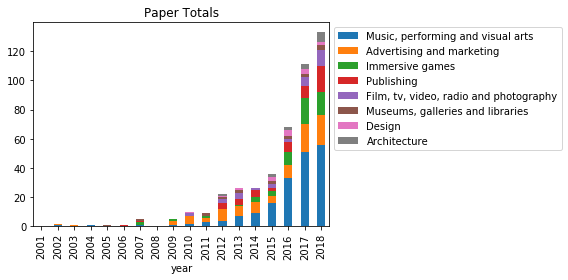

In [44]:
trends_total = trend_analysis(arx_pred,'year','ai',creative_sectors,thres=1,year_lims=[2000,2019],norm=0)

trends_total[top_sectors].plot.bar(stacked=True,title='Paper Totals',figsize=(8,4))
plt.legend(bbox_to_anchor=(1,1))

save_fig('sector_years')

### 4. Compare growth in CI AI vs all activity and other AI

In [45]:
ai_trends = pd.crosstab(arx_pred['year'],arx_pred['ai']).loc[np.arange(2001,2019)].apply(lambda x: x/x.sum())

ai_trends.columns = ['Not AI','All AI']

In [46]:
list(ai_trends.columns)+list(top_sectors)

['Not AI',
 'All AI',
 'Music, performing and visual arts',
 'Advertising and marketing',
 'Immersive games',
 'Publishing',
 'Film, tv, video, radio and photography',
 'Museums, galleries and libraries',
 'Design',
 'Architecture']

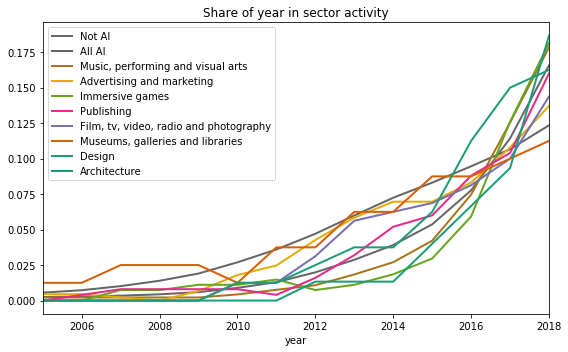

In [47]:
trend_shares = trends_total.apply(
    lambda x: x/x.sum(),axis=0)

all_sectors = pd.concat([ai_trends,trend_shares],axis=1)[list(ai_trends.columns)+list(top_sectors)]

all_sectors.rolling(window=5).mean().dropna().plot(linewidth=2,figsize=(8,5),title='Share of year in sector activity',cmap='Dark2_r')

save_fig('trends_share_year')

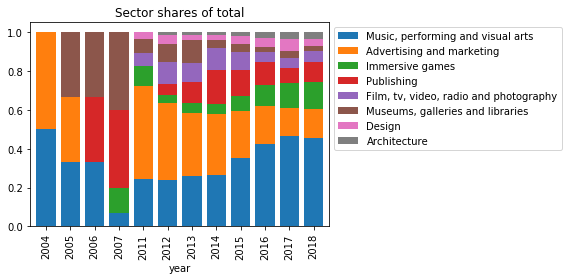

In [48]:
ax = trends_total.apply(lambda x: x/x.sum(),axis=1)[top_sectors].rolling(window=3).mean().dropna().plot.bar(stacked=True,width=0.8,
                                                                                                           title='Sector shares of total',figsize=(8,4))
ax.legend(bbox_to_anchor=(1,1))

save_fig('sector_years_shares')

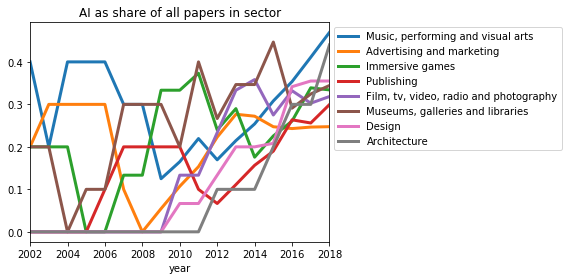

In [49]:
trends_mean = trend_analysis(arx_pred,'year','ai',creative_sectors,thres=1,year_lims=[1997,2019],norm=1)

ax = trends_mean[top_sectors].rolling(window=5).mean().dropna().plot(linewidth=3,title='AI as share of all papers in sector',figsize=(8,4))
ax.legend(bbox_to_anchor=(1,1))

save_fig('sector_years_share_of_sector')

#### 5. Geography

#Here, we will need to re-merge the papers with the initial geo-coded version

In [50]:
def create_lq_df(df):
    '''
    Takes a df with cells = activity in col in row and returns a df with cells = lq
    
    '''
    
    area_activity = df.sum(axis=0)
    area_shares = area_activity/area_activity.sum()
    
    lqs = df.apply(lambda x: (x/x.sum())/area_shares, axis=1)
    return(lqs)



In [51]:
#Here we merge the arx enriched dataset with the 
arx_ci_geo = pd.merge(arx,arx_pred[['article_id','year']+list(sect_labels)],left_on='article_id',right_on='article_id')

#arx_ci_geo['year'] = [int(x.split('-')[0]) for x in arx_ci_geo['year_created']]
    

In [52]:
#Drop the multinationals
arx_ci_geo_nom = arx_ci_geo.loc[arx_ci_geo['is_multinational']==0].reset_index(drop=True)

In [53]:
arx_ci_geo_nom.head()

,Unnamed: 0,article_id,article_created,article_updated,article_title,journal_ref,doi,summary,citation_count,citation_count_updated,...,ai,year,kw_n_advertising_and_marketing,kw_n_architecture,kw_n_immersive_games,kw_n_design,"kw_n_film,_tv,_video,_radio_and_photography","kw_n_museums,_galleries_and_libraries","kw_n_music,_performing_and_visual_arts",kw_n_publishing
0,0,0704.0002,2007-03-30,2008-12-13,Sparsity-certifying Graph Decompositions,NaN,NaN,"We describe a new algorithm, the $(k,\ell)$-...",18.0,2019-04-12,...,False,2007,0,0,0,0,0,0,0,0
1,1,0704.0002,2007-03-30,2008-12-13,Sparsity-certifying Graph Decompositions,NaN,NaN,"We describe a new algorithm, the $(k,\ell)$-...",18.0,2019-04-12,...,False,2007,0,0,0,0,0,0,0,0
2,2,0704.0046,2007-04-01,NaN,A limit relation for entropy and channel capac...,"J. Math. Phys. 48(2007), 092102.",10.1063/1.2779138,"In a quantum mechanical model, Diosi, Feldma...",1.0,2019-05-20,...,False,2007,0,0,0,0,0,0,0,0
3,3,0704.0046,2007-04-01,NaN,A limit relation for entropy and channel capac...,"J. Math. Phys. 48(2007), 092102.",10.1063/1.2779138,"In a quantum mechanical model, Diosi, Feldma...",1.0,2019-05-20,...,False,2007,0,0,0,0,0,0,0,0
4,4,0704.0046,2007-04-01,NaN,A limit relation for entropy and channel capac...,"J. Math. Phys. 48(2007), 092102.",10.1063/1.2779138,"In a quantum mechanical model, Diosi, Feldma...",1.0,2019-05-20,...,False,2007,0,0,0,0,0,0,0,0


In [54]:
# Now we have a df with individual country - sector

def geo_analysis(df,ai_var,geo_var,sector_names,threshold,top_c=False):
    '''
    
    Create distributions of activity by sector and geography
    
    Args:
        -df is the table with the information, every row is an entity with geographical information, ai information, sector information etc
        -ai_var is the ai variable
        -geo_var is the variable with the countries
        -sector_names is the sectors we want to extract information for
        -threshold is the threshold above which we accept a paper as 'creative'
        -top_c is the number of countries we want to output
    
    Outputs:
        -Table with counts of papers by country and sector. We can normalise later.

    '''
    
    #Table
    country_dist = pd.concat([df.loc[(df[ai_var]==True)&(df[s]>threshold)][geo_var].value_counts() for s in sector_names],axis=1).fillna(0)
    
    country_dist.columns = [' '.join(x.split('_')[2:]).capitalize() for x in sector_names]
    
    country_dist = country_dist.loc[country_dist.sum(axis=1).sort_values(ascending=False).index]
    
    if top_c!=False:
        
        country_dist = country_dist.iloc[top_c]
    
    return(country_dist)
    
    
    
    



In [ ]:
geo = geo_analysis(arx_ci_geo_nom,'ai','institute_country',creative_sectors,threshold=1)

ax = geo.iloc[:15][top_sectors].plot.bar(stacked=True,title='Papers by sector and country',figsize=(8,4))

ax.legend(bbox_to_anchor=(1,1))

save_fig('country_totals')

###### 6. Market 'shares'

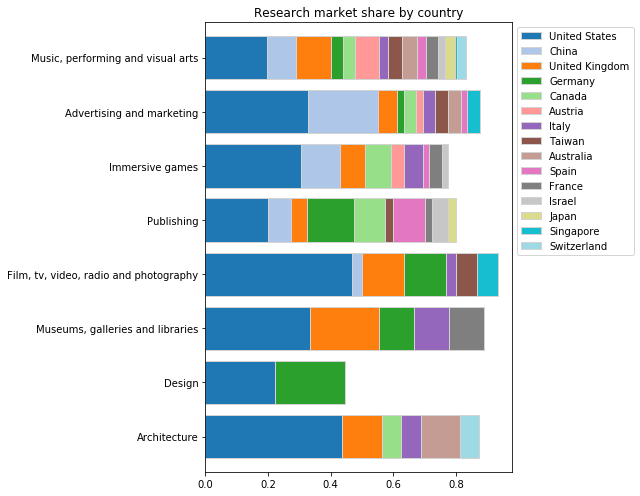

In [56]:
ax = geo.apply(lambda x: x/x.sum(),axis=0)[top_sectors[::-1]].iloc[:15].T.plot.barh(
    stacked=True,cmap='tab20',edgecolor='lightgrey',figsize=(9,7),width=0.8,title='Research market share by country')

ax.legend(bbox_to_anchor=(1,1))

save_fig('copuntry_market_shares')

#### 7. Evolution of activity

In [57]:
def make_sector_year_trend(df,year_var,geo_var):
    '''
    Creates a table with number of papers by country and year
    
    
    '''
    
    country_year = pd.crosstab(df[year_var],df[geo_var])
    
    return(country_year)

In [58]:
sector_name_mapping = {' '.join(x.split('_')[2:]).capitalize():x for x in creative_sectors}

In [59]:
def geo_trends(df,ai_var,year_var,geo_var,sector_names,threshold,top_c=False,year_lims= False):
    
    '''
    Visualise geotrends by sector
    
    Creates a set of tables for each sector with number of papers by country and year
    
    args:
    
        -df is the table with the information, every row is an entity with geographical information, ai information, sector information etc
        -ai_var is the ai variable
        -geo_var is the variable with the countries
        -sector_names is the sectors we want to extract information for
        -threshold is the threshold above which we accept a paper as 'creative'
        -top_c is the number of countries we want to output
        
    
    
    '''
    #We focus on ai papers
    
    ai_papers = df.loc[df[ai_var]==True]
    
    #We store the sectoral results here
    sector_store = {}
    
    #For each sector
    for s in sector_names:
        
        #Calculate number of papers in sector by year and country
        
        out = make_sector_year_trend(ai_papers.loc[ai_papers[s]>threshold],year_var,geo_var).fillna(0)
        
        #This is to focus on popular countries (if we want)
        if top_c!=False:
            top_cs = out.sum(axis=0).sort_values(ascending=False).index[:top_c]
            out = out[top_cs]
            
        #This is to limit the number of years we focus on
        if year_lims!=False:
            
            out = out.loc[(out.index>year_lims[0]) & (out.index<year_lims[1])]
        
        
        #out['sector']=s
        sector_store[s]=out
    
    return(sector_store)
        
    

In [60]:
all_trends = arx_pred

In [61]:
sector_trends = geo_trends(arx_ci_geo,'ai','year','institute_country',creative_sectors,threshold=1,top_c=5,year_lims=[2000,2019])

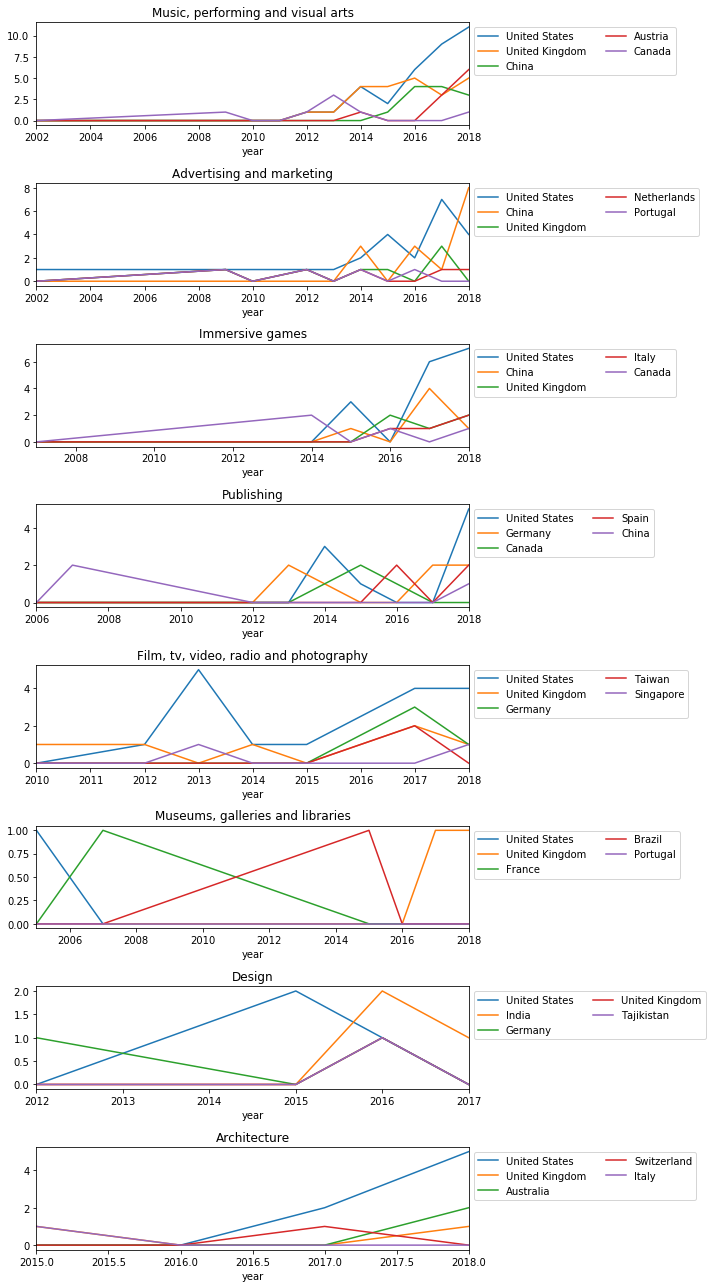

In [62]:
fig,ax = plt.subplots(nrows=len(creative_sectors),figsize=(10,18))

for n,s in enumerate(top_sectors):
    
    sector_trends[sector_name_mapping[s]].dropna().plot(ax=ax[n],title=s)
    
    #print(sector_trends[sector_name_mapping[s]].rolling(window=4).mean())
    
    ax[n].legend(bbox_to_anchor=(1,1),ncol=2)
    
plt.tight_layout()

In [63]:
#Calculate UK shares of total

In [64]:
def geo_trends_country(df,ai_var,year_var,geo_var,sector_names,threshold,country,top_c=False,year_lims= False):
    
    '''
    Visualise geotrends by sector
    
    Creates a set of tables for each sector with number of papers by country and year
    
    args:
    
        -df is the table with the information, every row is an entity with geographical information, ai information, sector information etc
        -ai_var is the ai variable
        -geo_var is the variable with the countries
        -sector_names is the sectors we want to extract information for
        -threshold is the threshold above which we accept a paper as 'creative'
        -top_c is the number of countries we want to output
        
    
    
    '''
    #We focus on ai papers
    

    
    ai_papers = df.loc[df[ai_var]==True]
    
    #We store the sectoral results here
    sector_store = {}
    
    #Also for all papers (as a benchmark)
    
    all_papers = make_sector_year_trend(df,year_var,geo_var)
    
    all_papers_shares = all_papers.apply(lambda x: x/x.sum(),axis=1)
    
    sector_store['All'] = all_papers_shares[country]
    
    #For each sector
    for s in sector_names:
        
        #Calculate number of papers in sector by year and country
        
        out = make_sector_year_trend(ai_papers.loc[ai_papers[s]>threshold],year_var,geo_var).fillna(0)
        
        
        out_shares = out.apply(lambda x: x/x.sum(),axis=1)
        
        #This is to limit the number of years we focus on
        if year_lims!=False:
            
            out_shares = out_shares.loc[(out_shares.index>year_lims[0]) & (out_shares.index<year_lims[1])]
        
        
        #out['sector']=s
        sector_store[s]=out_shares[country]
    
    return(sector_store)
        

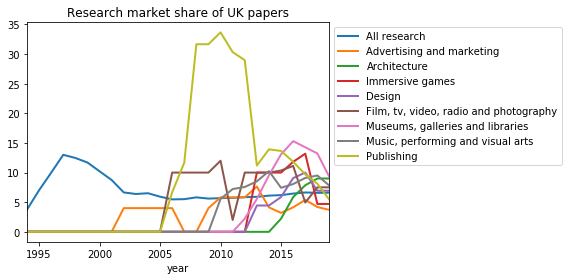

In [65]:
uk = pd.DataFrame(geo_trends_country(arx_ci_geo_nom,'ai','year','institute_country',creative_sectors,0,'United Kingdom',year_lims=[2000,2019])).fillna(0)

uk.columns =  ['All research']+[' '.join(x.split('_')[2:]).capitalize() for x in uk.columns[1:]]

ax = (100*uk.rolling(window=5).mean()).dropna().plot(linewidth=2,title='Research market share of UK papers',figsize=(8,4))

ax.legend(bbox_to_anchor=(1,1))

save_fig('country')

#### 8. Specialisation (discretised)

In [66]:
def make_specialisation_table(geo_df,top):
    '''
    Creates a specialisation table.
    
    Args:
        geo df is a table with geographical units in the rows and sector activity in the columns
        top is the number of geographical units to report
        
    Returns:
        A table for a heatmap visualisation
    
    
    '''
    
    lqs = create_lq_df(geo_df)
    
    #Select, arrange and rank
    select = lqs.iloc[:top].apply(lambda x: pd.qcut(x,np.arange(0,1.1,0.2),labels=False,duplicates='drop'),axis=1)
    
    return(select)

In [ ]:
all_ai_country = pd.crosstab(arx_ci_geo_nom['institute_country'],arx_ci_geo_nom['ai'])

all_ai_country.columns = ['Non AI','all_AI']

ai_non_ci = arx_ci_geo_nom.loc[(arx_ci_geo_nom[creative_sectors].max(axis=1)<2)&(arx_ci_geo_nom['ai']==True)]

ai_non_ci_country = pd.crosstab(ai_non_ci['institute_country'],ai_non_ci['ai'])

ai_non_ci_country.columns = ['AI non CI']

geo_all = pd.concat([all_ai_country['Non AI'],ai_non_ci_country['AI non CI'],geo],axis=1).fillna(0)

In [68]:
geo_all_sorted = geo_all.loc[geo_all[top_sectors].sum(axis=1).sort_values(ascending=False).index]

In [69]:
list(geo_all_sorted.columns[:2])+list(top_sectors)

['Non AI',
 'AI non CI',
 'Music, performing and visual arts',
 'Advertising and marketing',
 'Immersive games',
 'Publishing',
 'Film, tv, video, radio and photography',
 'Museums, galleries and libraries',
 'Design',
 'Architecture']

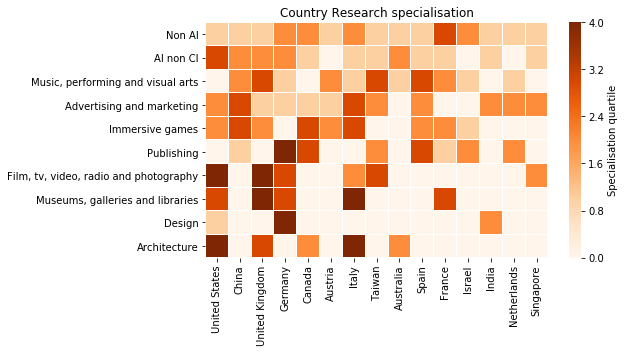

In [70]:
fig,ax = plt.subplots(figsize=(9,5))

ax = sn.heatmap(make_specialisation_table(geo_all_sorted[list(geo_all_sorted.columns[:2])+list(top_sectors)],15).T,cmap='Oranges',
          edgecolor='lighgrey',linewidth=0.01,ax=ax)

ax.set_title('Country Research specialisation')

ax.collections[0].colorbar.set_label("Specialisation quartile")

save_fig('sector_specs')

### 9. Institutional analysis

Here we create a df where one of the fields is a list with the institutions involved.

We will use this to identify the most active organisations by sector

In [71]:
arx_inst = arx_ci_geo.copy().dropna(axis=0,subset=['institute_name'])

In [72]:
#Clean up the institution names to remove duplicated matches 
arx_inst['institute_ded'] = [x.split('(')[0] for x in arx_inst['institute_name']]

In [73]:
#Group by paper and drop duplicates

arx_inst_unique = arx_inst.drop_duplicates('article_id')[[x for x in arx_inst.columns if not any(var in x for var in ['country','state','lat','lon','city','multinational','inst'])]]

inst_per_paper = arx_inst.groupby('article_id')['institute_ded'].apply(lambda x: list(set(x))).to_dict()

In [74]:
#Assign the institution lists to the papers
arx_inst_unique['institute_list'] = [inst_per_paper[x] for x in arx_inst_unique['article_id']]

In [75]:
def make_inst_counts(df,inst_var):
    '''
    Counts institutions in a df
    
    '''
    
    out = pd.Series(flatten_list(df[inst_var])).value_counts()
    return(out)

In [76]:
def top_institutions(df,ai_var,inst_var,year_var,sector_names,threshold,top_insts=5,year_lims=[2008,2019]):
    '''
    Extracts the top institutions in each sector and the evolution of concentration
    
    Args:
        -df is the table with the information, every row is an entity with institutional information, ai information, sector information etc
        -ai_var is the ai variable
        -inst var is the variable with the institutions
        -sector_names is the sectors we want to extract information for
        -threshold is the threshold above which we accept a paper as 'creative' in a sector
        -top_c is the number of institutes we want to output

    Returns a table with top institutions and the evolution of concentration over time
    
    '''
    
    #Get the totals for each sector
    
    out = {}
    
    for s in sector_names:
        
        #Append the total papers per institution
        tot = make_inst_counts(df.loc[(df[ai_var]==True)& (df[s]>threshold)],inst_var).sort_values(ascending=False)
        
        #top_inst_store[s] = tot.iloc[:top_insts]
        
        #Get the yearly activity
        
        #Combine by year
        tot_year = pd.concat([make_inst_counts(df.loc[(df[ai_var]==True)& (df[s]>threshold) & (df[year_var]==y)],inst_var).reset_index(drop=True).sort_values(ascending=False) for y in 
                              np.arange(year_lims[0],year_lims[1])],axis=1).fillna(0)
        
        
        tot_year.columns = np.arange(year_lims[0],year_lims[1])
        
        #print(tot_year)
        
        top_x = tot_year.apply(lambda x: x/x.sum()).iloc[:top_insts].sum(axis=0)
        
        #print(top_x.iloc[:top_insts].sum(axis=0))
        
        
        out[s] = [tot.iloc[:top_insts],top_x]
            
    return(out)
        
        
    
    
    

In [77]:
# for s in sector_names:
        
#         #Append the total papers per institution
#         tot = make_inst_counts(df.loc[(df[ai_var]==True)& (df[s]>threshold)],inst_var).sort_values(ascending=False)
        
#         top_inst_store.append(tot.iloc[:top_insts])
        
#         #Get the yearly activity
        
#         #Combine by year
#         tot_year = pd.concat([make_inst_counts(df.loc[(df[ai_var]==True)& (df[s]>threshold) & (df[year_var]==y)],inst_var).sort_values(ascending=False) for y in 
#                               np.arange(year_lims[0],year_lims[1])],axis=1)

In [78]:
inst = top_institutions(arx_inst_unique,'ai','institute_list','year',creative_sectors,1,top_insts=20)

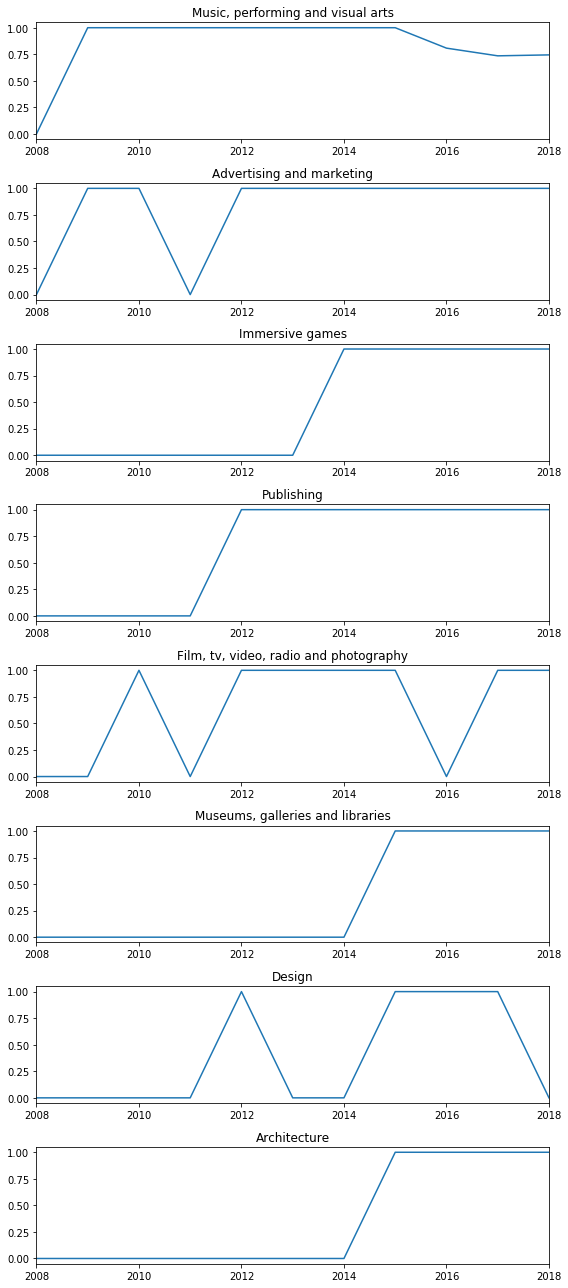

In [79]:
fig,ax = plt.subplots(nrows=len(creative_sectors),figsize=(8,18))

for n,s in enumerate(top_sectors):
    
    #inst[sector_name_mapping[s]][0].plot.barh(ax=ax[n][0],title=s)
    
    inst[sector_name_mapping[s]][1].plot(ax=ax[n],title=s)
    
    
    #ax[n].legend(bbox_to_anchor=(1,1),ncol=2)
    
plt.tight_layout()

save_fig('top_institutions')

arx_ci_geo_nom.loc[arx_ci_geo_nom['institute_country']=='United Kingdom'].to_csv(f'../data/processed/{today_str}_arxiv_uk_papers.csv',compression='zip')

### 10. Stuff for the report

In [81]:
len(arx_pred.loc[arx_pred[creative_sectors].max(axis=1)>1])

1574

In [82]:
len(arx_pred.loc[(arx_pred[creative_sectors].max(axis=1)>1) & (arx_pred['ai']==True)])

458

In [83]:
5017/12517

0.4008148917472238

In [84]:
len(arx_pred.loc[(arx_pred['ai']==True)])/len(arx_pred)

0.2613142709650324

In [85]:
100*5000/arx_pred['ai'].sum()

8.370722560771446

In [86]:
# for s in creative_sectors:
    
#     print(s)
#     print('===')
    
#     summ = arx_pred.aloc[(arx_pred[s]>2)&(arx_pred['ai']==True)].sort_values('citation_count',ascending=False)['summary'].iloc[0]
#     print(summ)
    
#     print('/n')

In [87]:
len(arx_ci_geo_nom.loc[(arx_ci_geo_nom[creative_sectors].max(axis=1)>1)&(arx_ci_geo_nom['institute_country']=='United States')])/12157

0.026322283458089988

In [88]:
100*len(arx_ci_geo_nom.loc[(arx_ci_geo_nom[creative_sectors].max(axis=1)>1)&(arx_ci_geo_nom['institute_country']=='China')])/12157

0.6580570864522497

In [89]:
100*len(arx_ci_geo_nom.loc[(arx_ci_geo_nom[creative_sectors].max(axis=1)>1)&(arx_ci_geo_nom['institute_country']=='United Kingdom')])/12157

0.6662828000329029

## 11. Topic modelling

We will use a stochastic block model topic modelling approach that automatically selects the number of topics and displays them as a hierarchy.

In [ ]:
# # Imports

#Imports
from sbmtm import sbmtm
import graph_tool.all as gt

def make_document_topic_df(model,level,n_words):
    '''
    
    We extract a document-topic df from the model.
    
    Arguments:
        model: model object
        level (int): level of the model at which we want to extract the topics
        n_words: number of words we want to use to label the columns in the document-topic df
        
    Outputs:
        A document topic df where every row is a paper (with its id) and each column is the the weight for a topic. The columns are labelled with the topic names
    
    
    '''
    
    #Create the topic mix
    d_t_df = pd.concat([pd.DataFrame(model.topicdist(n,l=level),columns=['topic',pid]).set_index('topic') for 
                      n,pid in enumerate(model.documents)],axis=1).T
    
    #Create the columns
    topic_names = ['-'.join([x[0] for x in topic_comp][:n_words]) for topic_comp in model.topics(l=level).values()]
    
    d_t_df.columns = topic_names
    
    #We name the index to simplify merging later
    d_t_df.index.name = 'paper_id'
    
    return(d_t_df)

In [91]:
#Create a dataframe that contains only the AI papers. We can use this for the topic modelling

arx_ci_ai = arx_pred.loc[(arx_pred[sect_labels].sum(axis=1)>1) & (arx_pred['ai']==True)]

arx_ci_indices = set(arx_ci_ai.index)

In [ ]:
#Extract the bag of words abstracts for AI papers
arx_ci_ai_tok = [x for n,x in enumerate(arxiv_pro.tokenised) if n in arx_ci_indices]

In [ ]:
%%time
## we create an instance of the sbmtm-class
model = sbmtm()

## we have to create the word-document network from the corpus
model.make_graph(arx_ci_ai_tok,
                 documents=list(arx_ci_ai['article_id']))

## fit the model
gt.seed_rng(32) ## seed for graph-tool's random number generator --> same results
model.fit()

In [ ]:
topic_mix = make_document_topic_df(model,0,5)

In [ ]:
import seaborn as sns

In [ ]:
out_labels.sum()